In [6]:
import pandas as pd
import sklearn
import statsmodels as sm
import numpy as np
import sktime

from typing import List

from statsmodels.tsa.ar_model import AutoReg

from sklearn.model_selection import train_test_split

from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.model_evaluation import evaluate

from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from autots import AutoTS

C:\Users\335185\AppData\Local\Temp\ipykernel_14980\2216821479.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
print('Hello World')

Hello World


# Work Based Project
Initial Development Notebook

## Plan
1. Load the data
2. Clean the data
3. Reshape, resample (turn from monthly to quarterly)
4. Specify our model
5. Fit model
6. Predict
7. Evaluation (rolling OOS)



### Step 1: Load the data

In [8]:
input_data_dict = pd.read_excel('input data.xlsx', sheet_name=None)

for sheet_name, df in input_data_dict.items():
    print(f"Sheet name: {sheet_name}")

Sheet name: Instructions
Sheet name: dep
Sheet name: mind
Sheet name: quarterly
Sheet name: mserv
Sheet name: mprod
Sheet name: mconst
Sheet name: weights
Sheet name: GDP - low-level aggregates


### Step 2: Clean the data

In [9]:
# This is the first estimate of Quarterly GDP each quarter, turned into a time series
qgdp = input_data_dict['dep']

qgdp.index = pd.to_datetime(qgdp['Date'])
qgdp = qgdp.drop(['Date'], axis=1)
qgdp = qgdp.dropna()
qgdp = qgdp.rename(columns={'gdp': 'Quarterly GDP growth'})

qgdp.info()
qgdp.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Quarterly GDP growth  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


,Quarterly GDP growth
Date,
1990-03-31,0.462645
1990-06-30,0.990487
1990-09-30,-1.282870
1990-12-31,-0.928221
1991-03-31,-0.470855


In [10]:
# Monthly indicators
m_ind = input_data_dict['mind']

m_ind.index = pd.to_datetime(m_ind['Date'])
m_ind = m_ind.drop(['Date'], axis=1)
m_ind = m_ind.dropna()

m_ind

,cipsto,cipste,cipstn,cbito,cbite,lbbba
Date,,,,,,
2003-10-31,59.019121,72.009759,57.887877,-8.0,8.0,53.0
2003-11-30,59.032192,74.245034,59.223734,2.0,15.0,38.0
2003-12-31,58.246338,75.003468,58.332699,7.0,18.0,62.0
2004-01-31,59.260138,76.271992,60.703809,20.0,29.0,53.0
2004-02-29,58.443636,73.355040,58.819207,18.0,33.0,55.0
...,...,...,...,...,...,...
2024-01-31,52.900000,70.600000,52.200000,-11.0,3.0,58.0
2024-02-29,52.979231,74.968075,52.261940,-6.0,5.0,52.0
2024-03-31,52.900000,73.800000,52.000000,-12.0,11.0,55.0


In [11]:
# Quarterly indicators
q_ind = input_data_dict['quarterly']

q_ind.index = pd.to_datetime(q_ind['Date'])
q_ind = q_ind.drop(['Date'], axis=1)
# q_ind = q_ind.dropna()

q_ind.info()
q_ind.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 1990-03-31 to 2024-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bccto   137 non-null    float64
 1   bccte   137 non-null    float64
 2   bcctn   137 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


,bccto,bccte,bcctn
Date,,,
1990-03-31,18.123964,41.704425,16.628885
1990-06-30,9.697203,40.272566,7.574371
1990-09-30,-2.484248,25.056637,-7.316107
1990-12-31,-8.483257,15.192920,-16.487859
1991-03-31,-23.884248,20.056637,-25.688354


In [12]:
# monthly GDP services
m_serv = input_data_dict['mserv']

m_serv.index = pd.to_datetime(m_serv['Date'])
m_serv = m_serv.drop(['Date'], axis=1)

m_serv = m_serv.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_serv = m_serv.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_serv.loc[m_serv.index < pd.Timestamp("August 2000")]
m_serv = m_serv.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_serv.columns) < pd.Timestamp("August 2000")
m_serv = m_serv.drop(m_serv.loc[:, columns_to_drop].columns, axis=1)

m_serv.info()
m_serv.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.9,1.0,1.0,1.0,1.0,1.1,1.1,1.1,1.1,1.1,...,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8
2000-09-30,NaN,-0.3,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,...,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6
2000-10-31,NaN,NaN,0.1,0.0,0.1,0.2,0.2,0.2,0.2,0.2,...,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
2000-11-30,NaN,NaN,NaN,0.7,0.9,0.6,0.6,0.6,0.6,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


In [13]:
# monthly GDP production
m_prod = input_data_dict['mprod']

m_prod.index = pd.to_datetime(m_prod['Date'])
m_prod = m_prod.drop(['Date'], axis=1)

m_prod = m_prod.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_prod = m_prod.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_prod.loc[m_prod.index < pd.Timestamp("August 2000")]
m_prod = m_prod.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_prod.columns) < pd.Timestamp("August 2000")
m_prod = m_prod.drop(m_prod.loc[:, columns_to_drop].columns, axis=1)

m_prod.info()
m_prod.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.6,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259,1.312259
2000-09-30,NaN,-1.1,-1.0,-1.0,-0.9,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952,-0.434952
2000-10-31,NaN,NaN,-0.2,-0.2,0.0,-0.1,-0.1,-0.1,-0.1,-0.1,...,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371,0.408371
2000-11-30,NaN,NaN,NaN,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745,1.030745
2000-12-31,NaN,NaN,NaN,NaN,-0.6,-0.6,-0.6,-0.6,-0.6,-0.6,...,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208,2.532208


In [14]:
# monthly GDP construction
m_const = input_data_dict['mconst']

m_const.index = pd.to_datetime(m_const['Date'])
m_const = m_const.drop(['Date'], axis=1)

m_const = m_const.dropna(axis=1, how='all') # Drop all columns where all values are empty
m_const = m_const.dropna(axis=0, how='all') # Drop all rows where all values are empty

# Make it the right shape
rows_to_drop = m_const.loc[m_const.index < pd.Timestamp("August 2000")]
m_const = m_const.drop(rows_to_drop.index)

columns_to_drop = pd.to_datetime(m_const.columns) < pd.Timestamp("August 2000")
m_const = m_const.drop(m_const.loc[:, columns_to_drop].columns, axis=1)

m_const.info()
m_const.head()

# Column is the revision release data
# Rows are the values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Columns: 285 entries, 2000-08-01 00:00:00 to 2024-04-01 00:00:00
dtypes: float64(285)
memory usage: 636.8 KB


,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-10-31,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-11-30,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def rescale_weights(array_of_weights):
    """Rescales the weights to add up to 1"""
    return array_of_weights / sum(array_of_weights)

In [16]:
# Load the weights and transform to monthly from quarterly 
gdp_weights = input_data_dict['weights']

gdp_weights.index = pd.to_datetime(gdp_weights['Date'])
gdp_weights = gdp_weights.drop(['Date'], axis=1)
gdp_weights = gdp_weights.resample(rule='m').ffill()


gdp_weights = gdp_weights.apply(
    func=rescale_weights, # Function to apply
    axis=1, # Apply function to each row
    raw=True, # Pass the data as a array rather than series
    result_type='broadcast', # Keep the shape of the DF the same
)

# Reshape:
weights_to_drop = gdp_weights.loc[(gdp_weights.index < pd.Timestamp("August 2000")) | (gdp_weights.index > m_serv.index[-1])]
gdp_weights = gdp_weights.drop(weights_to_drop.index)

gdp_weights.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2000-08-31 to 2024-04-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   w_serv   285 non-null    float64
 1   w_prod   285 non-null    float64
 2   w_const  285 non-null    float64
dtypes: float64(3)
memory usage: 8.9 KB


C:\Users\335185\AppData\Local\Temp\ipykernel_14980\1878564410.py:6: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp_weights = gdp_weights.resample(rule='m').ffill()


In [17]:
# combine services, production and construction with their weights, to form monthly GDP
m_gdp = m_serv.mul(gdp_weights['w_serv'], axis=0) + m_prod.mul(gdp_weights['w_prod'], axis=0)  + m_const.mul(gdp_weights['w_const'], axis=0)

m_gdp

,2000-08-01,2000-09-01,2000-10-01,2000-11-01,2000-12-01,2001-01-01,2001-02-01,2001-03-01,2001-04-01,2001-05-01,...,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-31,0.836115,0.872229,0.872229,0.872229,0.872229,0.950934,0.950934,0.950934,0.950934,0.950934,...,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086,0.909086
2000-09-30,NaN,-0.470361,-0.291656,-0.291656,-0.270361,-0.249066,-0.249066,-0.249066,-0.249066,-0.249066,...,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853,-0.564853
2000-10-31,NaN,NaN,0.036115,-0.042590,0.078705,0.136115,0.136115,0.136115,0.136115,0.136115,...,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258,0.008258
2000-11-30,NaN,NaN,NaN,0.572229,0.729639,0.493525,0.493525,0.493525,0.493525,0.493525,...,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498,0.219498
2000-12-31,NaN,NaN,NaN,NaN,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,-0.600000,...,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465,1.011465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.029768,-0.029768,-0.036048,-0.036048,-0.036048
2024-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.202036,0.268512,0.327646,0.327646
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110611,0.250904,0.250904


### Step 3: Reshape the data - without vintages first

In [18]:
# Resample the quarterly indicators
q_resampled_ind = q_ind.resample('ME').ffill()


In [19]:
test_df = m_ind.merge(
    q_ind.resample('ME').ffill(), 
    left_index=True, 
    right_index=True, 
    how='inner'
).merge(
    m_gdp[m_gdp.columns[-1]],
    left_index=True,
    right_index=True,
    how='inner'
)

X = test_df.rename({test_df.columns[-1]: 'm_gdp'}, axis=1)
X.index.freq = 'ME'

X

,cipsto,cipste,cipstn,cbito,cbite,lbbba,bccto,bccte,bcctn,m_gdp
Date,,,,,,,,,,
2003-10-31,59.019121,72.009759,57.887877,-8.0,8.0,53.0,18.263393,51.568142,12.295492,0.120688
2003-11-30,59.032192,74.245034,59.223734,2.0,15.0,38.0,18.263393,51.568142,12.295492,-0.377613
2003-12-31,58.246338,75.003468,58.332699,7.0,18.0,62.0,24.812861,52.704425,20.142929,0.653732
2004-01-31,59.260138,76.271992,60.703809,20.0,29.0,53.0,24.812861,52.704425,20.142929,-0.395276
2004-02-29,58.443636,73.355040,58.819207,18.0,33.0,55.0,24.812861,52.704425,20.142929,0.294394
...,...,...,...,...,...,...,...,...,...,...
2023-11-30,50.653180,68.219176,49.598571,-11.0,-3.0,56.0,10.992920,36.136283,6.516248,0.190622
2023-12-31,52.148343,69.694714,51.799516,-8.0,-6.0,51.0,12.813451,40.488495,6.939398,-0.036048
2024-01-31,52.900000,70.600000,52.200000,-11.0,3.0,58.0,12.813451,40.488495,6.939398,0.327646


In [20]:
Y =  qgdp.resample('ME').ffill()
Y = Y.loc[Y.index >= X.index[0]]
Y.index.freq = 'ME'

Y

,Quarterly GDP growth
Date,
2003-10-31,0.600193
2003-11-30,0.600193
2003-12-31,0.900025
2004-01-31,0.900025
2004-02-29,0.900025
...,...
2023-11-30,-0.030000
2023-12-31,-0.344673
2024-01-31,-0.344673


In [21]:
# Make the feature data into a single dataframe, called X


# Make the target into a single dataframe, called y



# Transform the data
    # Make sure they're the same length
    # Make sure they're all for the same dates
    # Make sure they're all the same frequency

# Split X and y, using temporal_train_test_split into X_train, X_test, y_train, y_test

# Define a model
# Following the exmaple, fit the model to y_train, X_train
# Predict using the model using X_test

# Evaluate the predictions using y_test and the R^2 score thingy

# Done! For now...

### Step 4: Specify our model

In [22]:
# model_test = AutoReg(
#     endog=y_train,
#     lags=[1, 2, 3, 4, 5, 6],
#     exog=X_train,
#     trend='ct',
#     seasonal=False,
# )

# model_test = model_test.fit()

# model_test.summary()

In [23]:
# # Capital AutoREG is the sktime one...
# model = AutoREG(
#     lags=6,
#     trend='c'
# )

# model.fit(
#     y=y_train,
#     X=X_train,
#     fh=9,
# )


In [24]:
forecaster = AutoREG(
    lags=6,
    trend='c'
)

cv_strat_3m = ExpandingWindowSplitter(
    fh=[1, 2, 3],
    initial_window=100,
    step_length=1,
)

cv_strat_6m = ExpandingWindowSplitter(
    fh=[4, 5, 6],
    initial_window=100,
    step_length=1,
)

cv_strat_9m = ExpandingWindowSplitter(
    fh=[7, 8, 9],
    initial_window=100,
    step_length=1,
)

results_1Q = evaluate(
    forecaster=forecaster, 
    y=Y, 
    cv=cv_strat_3m, 
    X=X,
    scoring=[
        MeanAbsoluteScaledError(),
        MeanSquaredError(square_root=True),
        MeanAbsolutePercentageError(symmetric=True),
    ]
)

c:\Miniconda3\envs\Py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\envs\Py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\envs\Py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\envs\Py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Miniconda3\envs\Py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self.

<Axes: >

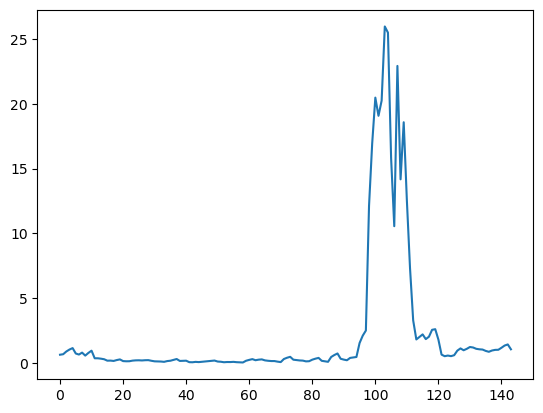

In [25]:
results_1Q['test_MeanSquaredError'].plot()

### Step 4.1: auto TS Model

In [26]:
# Specify model

model = AutoTS(
    forecast_length=3,
    model_list='fast',
    transformer_list='fast',
    max_generations=4,
    num_validations=2,
)

# Fit model - will pick the model 
model = model.fit(X)

# predict - evaluation / back forecasts 


Using 2 cpus for n_jobs.
Data frequency is: ME, used frequency is: ME
Model Number: 1 with model AverageValueNaive in generation 0 of 4
Model Number: 2 with model AverageValueNaive in generation 0 of 4
Model Number: 3 with model AverageValueNaive in generation 0 of 4
Model Number: 4 with model DatepartRegression in generation 0 of 4
Model Number: 5 with model DatepartRegression in generation 0 of 4
Model Number: 6 with model DatepartRegression in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 4
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 4
Model Number: 9 with model ETS in generation 0 of 4
Model Number: 10 with model GLM in generation 0 of 4
Model Number: 11 with model GLM in generation 0 of 4
Model Number: 12 with model GLS in generation 0 of 4
Model Number: 13 with model GLS in generation 0 of 4
Model Number: 14 with model LastValueNaive in generation 0 of 4
Model Number: 15 with model LastValueNaive in generation 0 of 4
Model Number: 16 with model LastValueNaive in generation 0 of 4
Model Number: 17 with model LastValueNaive in generation 0 of 4
Model Number: 18 with model SeasonalNaive in generation 0 of 4
Model Number: 19 with model SeasonalNaive in generation 0 of 4
Model Number: 20 with model SeasonalNaive in generation 0 of 4
Model Number: 21 with mode

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 30 with model ETS in generation 0 of 4
Model Number: 31 with model VECM in generation 0 of 4
Model Number: 32 with model UnivariateMotif in generation 0 of 4
Model Number: 33 with model UnivariateMotif in generation 0 of 4
Model Number: 34 with model SectionalMotif in generation 0 of 4
Model Number: 35 with model SectionalMotif in generation 0 of 4
Model Number: 36 with model SeasonalNaive in generation 0 of 4
Model Number: 37 with model DatepartRegression in generation 0 of 4
Model Number: 38 with model NVAR in generation 0 of 4
Model Number: 39 with model Cassandra in generation 0 of 4
Model Number: 40 with model SeasonalityMotif in generation 0 of 4
Model Number: 41 with model Cassandra in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df

Model Number: 42 with model Cassandra in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 43 with model Cassandra in generation 0 of 4
Model Number: 44 with model NVAR in generation 0 of 4
Model Number: 45 with model BallTreeMultivariateMotif in generation 0 of 4
Model Number: 46 with model SectionalMotif in generation 0 of 4
Model Number: 47 with model FFT in generation 0 of 4
Model Number: 48 with model ConstantNaive in generation 0 of 4
Model Number: 49 with model LastValueNaive in generation 0 of 4
Model Number: 50 with model AverageValueNaive in generation 0 of 4
Model Number: 51 with model GLS in generation 0 of 4
Model Number: 52 with model SeasonalNaive in generation 0 of 4
Model Number: 53 with model GLM in generation 0 of 4
Template Eval Error: NameError("free variable 'Xf' referenced before assignment in enclosing scope") in model 53 in generation 0: GLM
Model Number: 54 with model ETS in generation 0 of 4
Model Number: 55 with model VAR in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 56 with model VECM in generation 0 of 4
Model Number: 57 with model WindowRegression in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'xgboost'") in model 57 in generation 0: WindowRegression
Model Number: 58 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 58 in generation 0: DatepartRegression
Model Number: 59 with model UnivariateMotif in generation 0 of 4
Model Number: 60 with model SectionalMotif in generation 0 of 4
Model Number: 61 with model NVAR in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Miniconda3\envs\Py39\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
c:\Miniconda3\envs\Py39\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


Model Number: 62 with model MAR in generation 0 of 4
Model Number: 63 with model RRVAR in generation 0 of 4
Model Number: 64 with model KalmanStateSpace in generation 0 of 4
Model Number: 65 with model MetricMotif in generation 0 of 4
Model Number: 66 with model Cassandra in generation 0 of 4
Model Number: 67 with model SeasonalityMotif in generation 0 of 4
Model Number: 68 with model FFT in generation 0 of 4
Model Number: 69 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 69 in generation 0: BallTreeMultivariateMotif
Model Number: 70 with model MetricMotif in generation 0 of 4
Model Number: 71 with model LastValueNaive in generation 0 of 4
Model Number: 72 with model VECM in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 72 in generation 0: VECM
Model Number: 73 with model SectionalMotif in generation 0 of 

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 76 with model MetricMotif in generation 0 of 4
Model Number: 77 with model AverageValueNaive in generation 0 of 4
Model Number: 78 with model GLS in generation 0 of 4
Model Number: 79 with model BallTreeMultivariateMotif in generation 0 of 4
Template Eval Error: TypeError('1D weights expected when shapes of a and weights differ.') in model 79 in generation 0: BallTreeMultivariateMotif
Model Number: 80 with model ETS in generation 0 of 4
Model Number: 81 with model VAR in generation 0 of 4
Model Number: 82 with model SeasonalNaive in generation 0 of 4
Model Number: 83 with model BallTreeMultivariateMotif in generation 0 of 4
Model Number: 84 with model UnivariateMotif in generation 0 of 4
Model Number: 85 with model KalmanStateSpace in generation 0 of 4
Model Number: 86 with model RRVAR in generation 0 of 4
Model Number: 87 with model Cassandra in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40149e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.wh

Model Number: 88 with model ETS in generation 0 of 4
Model Number: 89 with model GLM in generation 0 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 89 in generation 0: GLM
Model Number: 90 with model Cassandra in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,


Model Number: 91 with model SectionalMotif in generation 0 of 4
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 91 in generation 0: SectionalMotif
Model Number: 92 with model MAR in generation 0 of 4
Model Number: 93 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 93 in generation 0: WindowRegression
Model Number: 94 with model BallTreeMultivariateMotif in generation 0 of 4
Model Number: 95 with model SeasonalityMotif in generation 0 of 4
Model Number: 96 with model AverageValueNaive in generation 0 of 4
Model Number: 97 with model UnivariateMotif in generation 0 of 4
Model Number: 98 with model MetricMotif in generation 0 of 4
Model Number: 99 with model GLM in generation 0 of 4
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and sho

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227261.484375, tolerance: 60.24909210205078
  ) = cd_fast.enet_coordinate_descent_multi_task(


Model Number: 110 with model LastValueNaive in generation 0 of 4
Model Number: 111 with model AverageValueNaive in generation 0 of 4
Model Number: 112 with model FFT in generation 0 of 4
Model Number: 113 with model AverageValueNaive in generation 0 of 4
Model Number: 114 with model BallTreeMultivariateMotif in generation 0 of 4
Model Number: 115 with model SeasonalityMotif in generation 0 of 4
Model Number: 116 with model SectionalMotif in generation 0 of 4
Model Number: 117 with model WindowRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 117 in generation 0: WindowRegression
Model Number: 118 with model ConstantNaive in generation 0 of 4
Model Number: 119 with model SeasonalNaive in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 120 with model LastValueNaive in generation 0 of 4
Model Number: 121 with model RRVAR in generation 0 of 4
Model Number: 122 with model GLS in generation 0 of 4
Model Number: 123 with model SeasonalNaive in generation 0 of 4
Model Number: 124 with model MAR in generation 0 of 4
Model Number: 125 with model WindowRegression in generation 0 of 4
Template Eval Error: ModuleNotFoundError("No module named 'xgboost'") in model 125 in generation 0: WindowRegression
Model Number: 126 with model ConstantNaive in generation 0 of 4
Model Number: 127 with model VECM in generation 0 of 4
Model Number: 128 with model UnivariateMotif in generation 0 of 4
Model Number: 129 with model WindowRegression in generation 0 of 4
Template Eval Error: Exception("Transformer HolidayTransformer failed on fit from params median {'0': {}, '1': {'method': 0.5}, '2': {'output_distribution': 'uniform', 'n_quantiles': 24}, '3': {'lag': 1, 'fill': 'bfill'}, '4': {'threshold': 0.9, 'splash_threshold': None,

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Template Eval Error: IndexError('index 223 is out of bounds for axis 0 with size 1') in model 131 in generation 0: UnivariateMotif
Model Number: 132 with model SeasonalNaive in generation 0 of 4
Model Number: 133 with model KalmanStateSpace in generation 0 of 4
Model Number: 134 with model VECM in generation 0 of 4
Model Number: 135 with model LastValueNaive in generation 0 of 4
Model Number: 136 with model DatepartRegression in generation 0 of 4
Model Number: 137 with model GLS in generation 0 of 4
Model Number: 138 with model ConstantNaive in generation 0 of 4
Model Number: 139 with model MetricMotif in generation 0 of 4
Model Number: 140 with model UnivariateMotif in generation 0 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 141 with model Cassandra in generation 0 of 4
Model Number: 142 with model LastValueNaive in generation 0 of 4
Model Number: 143 with model GLM in generation 0 of 4
Template Eval Error: NameError("free variable 'Xf' referenced before assignment in enclosing scope") in model 143 in generation 0: GLM
Model Number: 144 with model UnivariateMotif in generation 0 of 4
Model Number: 145 with model KalmanStateSpace in generation 0 of 4
Model Number: 146 with model LastValueNaive in generation 0 of 4
Model Number: 147 with model AverageValueNaive in generation 0 of 4
Model Number: 148 with model WindowRegression in generation 0 of 4
Model Number: 149 with model NVAR in generation 0 of 4
Model Number: 150 with model ETS in generation 0 of 4
Model Number: 151 with model GLM in generation 0 of 4
Template Eval Error: NameError("free variable 'Xf' referenced before assignment in enclosing scope") in model 151 in generation 0: GLM
Model Number: 152 with model ConstantNaive in generatio

c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 163 with model WindowRegression in generation 1 of 4
Model Number: 164 with model UnivariateMotif in generation 1 of 4
Model Number: 165 with model DatepartRegression in generation 1 of 4
Model Number: 166 with model ConstantNaive in generation 1 of 4
Model Number: 167 with model ETS in generation 1 of 4
Model Number: 168 with model MAR in generation 1 of 4
Model Number: 169 with model ConstantNaive in generation 1 of 4
Model Number: 170 with model DatepartRegression in generation 1 of 4
Model Number: 171 with model VAR in generation 1 of 4
Model Number: 172 with model GLS in generation 1 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 173 with model UnivariateMotif in generation 1 of 4
Model Number: 174 with model LastValueNaive in generation 1 of 4
Model Number: 175 with model ETS in generation 1 of 4
Model Number: 176 with model AverageValueNaive in generation 1 of 4
Model Number: 177 with model GLS in generation 1 of 4
Template Eval Error: Exception("Transformer DatepartRegression failed on fit from params ffill {'0': {'lag_1': 7, 'method': 'Mean'}, '1': {}, '2': {'regression_model': {'model': 'ElasticNet', 'model_params': {'l1_ratio': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}}, 'datepart_method': 'common_fourier_rw', 'polynomial_degree': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'AnomalyRemoval'}, 'transformation_params': {'0': {'method': 'zscore', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'model': 'ElasticNet', 'model_params': {}}}}}, 'method_params': {'dist

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 180 with model ETS in generation 1 of 4
Model Number: 181 with model MetricMotif in generation 1 of 4
Model Number: 182 with model SeasonalNaive in generation 1 of 4
Model Number: 183 with model AverageValueNaive in generation 1 of 4
Model Number: 184 with model SectionalMotif in generation 1 of 4
Model Number: 185 with model DatepartRegression in generation 1 of 4
Model Number: 186 with model Cassandra in generation 1 of 4
Model Number: 187 with model KalmanStateSpace in generation 1 of 4
Model Number: 188 with model MetricMotif in generation 1 of 4
Model Number: 189 with model MetricMotif in generation 1 of 4
Model Number: 190 with model ETS in generation 1 of 4
Model Number: 191 with model BallTreeMultivariateMotif in generation 1 of 4
Model Number: 192 with model Cassandra in generation 1 of 4
Model Number: 193 with model SeasonalNaive in generation 1 of 4
Model Number: 194 with model GLS in generation 1 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 195 with model KalmanStateSpace in generation 1 of 4
Model Number: 196 with model VAR in generation 1 of 4
Model Number: 197 with model WindowRegression in generation 1 of 4
Model Number: 198 with model Cassandra in generation 1 of 4
Model Number: 199 with model FFT in generation 1 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df

Model Number: 200 with model FFT in generation 1 of 4
Model Number: 201 with model NVAR in generation 1 of 4
Model Number: 202 with model LastValueNaive in generation 1 of 4
Model Number: 203 with model RRVAR in generation 1 of 4
Model Number: 204 with model SeasonalityMotif in generation 1 of 4
Model Number: 205 with model Cassandra in generation 1 of 4
Model Number: 206 with model AverageValueNaive in generation 1 of 4
Model Number: 207 with model SectionalMotif in generation 1 of 4
Model Number: 208 with model VECM in generation 1 of 4
Model Number: 209 with model DatepartRegression in generation 1 of 4
Model Number: 210 with model VAR in generation 1 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 211 with model DatepartRegression in generation 1 of 4
Model Number: 212 with model BallTreeMultivariateMotif in generation 1 of 4
Model Number: 213 with model UnivariateMotif in generation 1 of 4
Model Number: 214 with model BallTreeMultivariateMotif in generation 1 of 4
Model Number: 215 with model SeasonalNaive in generation 1 of 4
Model Number: 216 with model VAR in generation 1 of 4
Model Number: 217 with model LastValueNaive in generation 1 of 4
Model Number: 218 with model UnivariateMotif in generation 1 of 4
Model Number: 219 with model RRVAR in generation 1 of 4
Model Number: 220 with model ETS in generation 1 of 4
Model Number: 221 with model BallTreeMultivariateMotif in generation 1 of 4
Model Number: 222 with model AverageValueNaive in generation 1 of 4
Model Number: 223 with model SeasonalNaive in generation 1 of 4
Model Number: 224 with model ETS in generation 1 of 4
Model Number: 225 with model VECM in generation 1 of 4
Model Number: 226 with model Univaria

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 232 with model ConstantNaive in generation 1 of 4
Model Number: 233 with model GLS in generation 1 of 4
Model Number: 234 with model RRVAR in generation 1 of 4
Model Number: 235 with model SectionalMotif in generation 1 of 4
Model Number: 236 with model NVAR in generation 1 of 4
Model Number: 237 with model GLS in generation 1 of 4
Model Number: 238 with model VECM in generation 1 of 4
Model Number: 239 with model Cassandra in generation 1 of 4
Model Number: 240 with model SectionalMotif in generation 1 of 4
Model Number: 241 with model ETS in generation 1 of 4
Model Number: 242 with model GLS in generation 1 of 4
Model Number: 243 with model VAR in generation 1 of 4
Model Number: 244 with model DatepartRegression in generation 1 of 4
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 244 in generation 1: DatepartRegression
Model Number: 245 with model VECM in generation 1 of 4
Model Number: 

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 247 with model Cassandra in generation 1 of 4
Model Number: 248 with model KalmanStateSpace in generation 1 of 4
Model Number: 249 with model ConstantNaive in generation 1 of 4
Model Number: 250 with model LastValueNaive in generation 1 of 4
Model Number: 251 with model LastValueNaive in generation 1 of 4
Model Number: 252 with model Cassandra in generation 1 of 4
Model Number: 253 with model ConstantNaive in generation 1 of 4
Model Number: 254 with model VECM in generation 1 of 4
Model Number: 255 with model MAR in generation 1 of 4
Model Number: 256 with model LastValueNaive in generation 1 of 4
Model Number: 257 with model MetricMotif in generation 1 of 4
Model Number: 258 with model MetricMotif in generation 1 of 4
Model Number: 259 with model VECM in generation 1 of 4
Model Number: 260 with model AverageValueNaive in generation 1 of 4
Model Number: 261 with model ETS in generation 1 of 4
Model Number: 262 with model Cassandra in generation 1 of 4
Model Number: 263 wi

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 268 with model AverageValueNaive in generation 2 of 4
Model Number: 269 with model ETS in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:1512: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_with_last = pd.concat([self.last_values, df])
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:1512: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_with_last = pd.concat([self.last_values, df])


Model Number: 270 with model SeasonalNaive in generation 2 of 4
Model Number: 271 with model VECM in generation 2 of 4
Model Number: 272 with model VECM in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 272 in generation 2: VECM
Model Number: 273 with model LastValueNaive in generation 2 of 4
Model Number: 274 with model GLS in generation 2 of 4
Model Number: 275 with model UnivariateMotif in generation 2 of 4
Model Number: 276 with model RRVAR in generation 2 of 4
Model Number: 277 with model RRVAR in generation 2 of 4
Model Number: 278 with model Cassandra in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 279 with model WindowRegression in generation 2 of 4
Model Number: 280 with model Cassandra in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 281 with model FFT in generation 2 of 4
Model Number: 282 with model ConstantNaive in generation 2 of 4
Model Number: 283 with model SeasonalNaive in generation 2 of 4
Model Number: 284 with model VAR in generation 2 of 4
Model Number: 285 with model Cassandra in generation 2 of 4
Template Eval Error: ValueError('The covariance matrix of the support data is equal to 0, try to increase support_fraction') in model 285 in generation 2: Cassandra
Model Number: 286 with model AverageValueNaive in generation 2 of 4
Model Number: 287 with model KalmanStateSpace in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df

Model Number: 288 with model NVAR in generation 2 of 4
Model Number: 289 with model SeasonalNaive in generation 2 of 4
Model Number: 290 with model MAR in generation 2 of 4
Model Number: 291 with model VECM in generation 2 of 4
Model Number: 292 with model Cassandra in generation 2 of 4
Model Number: 293 with model AverageValueNaive in generation 2 of 4
Model Number: 294 with model AverageValueNaive in generation 2 of 4
Model Number: 295 with model SeasonalNaive in generation 2 of 4
Model Number: 296 with model SeasonalityMotif in generation 2 of 4
Model Number: 297 with model RRVAR in generation 2 of 4
Model Number: 298 with model KalmanStateSpace in generation 2 of 4
Model Number: 299 with model ETS in generation 2 of 4
Model Number: 300 with model MetricMotif in generation 2 of 4
Model Number: 301 with model SeasonalityMotif in generation 2 of 4
Model Number: 302 with model DatepartRegression in generation 2 of 4
Model Number: 303 with model LastValueNaive in generation 2 of 4
Model

c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 329 with model VAR in generation 2 of 4
Model Number: 330 with model SectionalMotif in generation 2 of 4
Model Number: 331 with model WindowRegression in generation 2 of 4
Model Number: 332 with model Cassandra in generation 2 of 4
Template Eval Error: ValueError('The covariance matrix of the support data is equal to 0, try to increase support_fraction') in model 332 in generation 2: Cassandra
Model Number: 333 with model BallTreeMultivariateMotif in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 334 with model WindowRegression in generation 2 of 4
Model Number: 335 with model WindowRegression in generation 2 of 4
Model Number: 336 with model NVAR in generation 2 of 4
Model Number: 337 with model GLS in generation 2 of 4
Model Number: 338 with model LastValueNaive in generation 2 of 4
Model Number: 339 with model Cassandra in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 340 with model MAR in generation 2 of 4
Model Number: 341 with model ETS in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40149e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 342 with model SectionalMotif in generation 2 of 4
Model Number: 343 with model VECM in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 343 in generation 2: VECM
Model Number: 344 with model RRVAR in generation 2 of 4
Template Eval Error: Exception("Transformer Detrend failed on fit from params median {'0': {}, '1': {'lag_1': 12, 'method': 'Mean'}, '2': {'model_name': 'ucm_deterministictrend_seasonal7', 'state_transition': [[1, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, -1, -1, -1, -1, -1, -1]], 'process_noise': [[0.001, 0, 0, 0, 0, 0, 0, 0], [0, 0.001, 0, 0, 0, 0, 0, 0], [0, 0, 0.001, 0, 0, 0, 0, 0], [0, 0, 0, 0.001, 0, 0, 0, 0], [0, 0, 0, 0, 0.001, 0, 0, 0], [0, 0, 0, 0, 0, 0.001, 0, 0], [0, 0, 0, 0, 0, 0, 0.001, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'observation_model

c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 353 with model NVAR in generation 2 of 4
Model Number: 354 with model UnivariateMotif in generation 2 of 4
Model Number: 355 with model KalmanStateSpace in generation 2 of 4
Model Number: 356 with model RRVAR in generation 2 of 4
Model Number: 357 with model SectionalMotif in generation 2 of 4
Model Number: 358 with model LastValueNaive in generation 2 of 4
Model Number: 359 with model BallTreeMultivariateMotif in generation 2 of 4
Model Number: 360 with model BallTreeMultivariateMotif in generation 2 of 4
Model Number: 361 with model LastValueNaive in generation 2 of 4
Model Number: 362 with model BallTreeMultivariateMotif in generation 2 of 4
Model Number: 363 with model ETS in generation 2 of 4
Model Number: 364 with model NVAR in generation 2 of 4
Model Number: 365 with model ETS in generation 2 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40149e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 366 with model RRVAR in generation 2 of 4
Model Number: 367 with model DatepartRegression in generation 2 of 4
Model Number: 368 with model MetricMotif in generation 2 of 4
Model Number: 369 with model MetricMotif in generation 2 of 4
Model Number: 370 with model RRVAR in generation 2 of 4
Model Number: 371 with model LastValueNaive in generation 2 of 4
Model Number: 372 with model ETS in generation 2 of 4
Model Number: 373 with model AverageValueNaive in generation 2 of 4
Model Number: 374 with model VAR in generation 2 of 4
Model Number: 375 with model LastValueNaive in generation 2 of 4
Model Number: 376 with model AverageValueNaive in generation 2 of 4
Model Number: 377 with model FFT in generation 2 of 4
New Generation: 3 of 4
Model Number: 378 with model KalmanStateSpace in generation 3 of 4
Model Number: 379 with model NVAR in generation 3 of 4
Model Number: 380 with model FFT in generation 3 of 4
Model Number: 381 with model UnivariateMotif in generation 3 of 4
Mo

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227349.51863100193, tolerance: 51.01406989510631
  ) = cd_fast.enet_coordinate_descent_multi_task(


Model Number: 387 with model FFT in generation 3 of 4
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params median {'0': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gblinear', 'max_depth': 6, 'eta': 1.0, 'min_child_weight': 5, 'subsample': 1, 'colsample_bylevel': 0.5, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 4}, 'datepart_method': 'common_fourier'}, 'fillna': 'pchip'}, '1': {}, '2': {'rows': 4, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None, 'threshold_method': 'max'}}") in model 387 in generation 3: FFT
Model Number: 388 with model ETS in generation 3 of 4
Model Number: 389 with model NVAR in generation 3 of 4
Model Number: 390 with model RRVAR in generation 3 of 4
Model Number: 391 with model NVAR in generation 3 of 4
Model Number: 392 with model RRVAR in generation 3 of 4
Model Number: 393 with model AverageValueNaive in generation 3 of 4
Model Number: 

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40149e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 417 with model LastValueNaive in generation 3 of 4
Model Number: 418 with model AverageValueNaive in generation 3 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157592.13169400377, tolerance: 49.22696168604953
  ) = cd_fast.enet_coordinate_descent_multi_task(


Model Number: 419 with model LastValueNaive in generation 3 of 4
Model Number: 420 with model ETS in generation 3 of 4
Model Number: 421 with model NVAR in generation 3 of 4
Model Number: 422 with model SeasonalityMotif in generation 3 of 4
Model Number: 423 with model WindowRegression in generation 3 of 4
Model Number: 424 with model Cassandra in generation 3 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 425 with model LastValueNaive in generation 3 of 4
Model Number: 426 with model ConstantNaive in generation 3 of 4
Model Number: 427 with model WindowRegression in generation 3 of 4
Model Number: 428 with model SeasonalityMotif in generation 3 of 4
Model Number: 429 with model AverageValueNaive in generation 3 of 4
Model Number: 430 with model SectionalMotif in generation 3 of 4
Model Number: 431 with model NVAR in generation 3 of 4
Model Number: 432 with model MetricMotif in generation 3 of 4
Model Number: 433 with model KalmanStateSpace in generation 3 of 4
Model Number: 434 with model SeasonalNaive in generation 3 of 4
Model Number: 435 with model KalmanStateSpace in generation 3 of 4
Model Number: 436 with model SeasonalNaive in generation 3 of 4
Model Number: 437 with model VAR in generation 3 of 4
Model Number: 438 with model LastValueNaive in generation 3 of 4
Model Number: 439 with model Cassandra in generation 3 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, 

Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 439 in generation 3: Cassandra
Model Number: 440 with model VAR in generation 3 of 4
Model Number: 441 with model MAR in generation 3 of 4
Model Number: 442 with model MetricMotif in generation 3 of 4
Model Number: 443 with model NVAR in generation 3 of 4
Model Number: 444 with model SectionalMotif in generation 3 of 4
Model Number: 445 with model NVAR in generation 3 of 4
Model Number: 446 with model KalmanStateSpace in generation 3 of 4
Model Number: 447 with model UnivariateMotif in generation 3 of 4
Model Number: 448 with model UnivariateMotif in generation 3 of 4
Model Number: 449 with model MAR in generation 3 of 4
Model Number: 450 with model AverageValueNaive in generation 3 of 4
Model Number: 451 with model BallTreeMultivariateMotif in generation 3 of 4
Model Number: 452 with model ETS in generation 3 of 4
Model Number: 453 with model RRVAR in generation 3 of 4
Model Number: 454 with model BallTr

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1102185.125, tolerance: 97798.8515625
  ) = cd_fast.enet_coordinate_descent_multi_task(
c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.40149e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 466 with model LastValueNaive in generation 3 of 4
Model Number: 467 with model VECM in generation 3 of 4
Model Number: 468 with model AverageValueNaive in generation 3 of 4
Model Number: 469 with model FFT in generation 3 of 4
Model Number: 470 with model UnivariateMotif in generation 3 of 4
Model Number: 471 with model MetricMotif in generation 3 of 4
Model Number: 472 with model GLM in generation 3 of 4
Model Number: 473 with model LastValueNaive in generation 3 of 4
Model Number: 474 with model ConstantNaive in generation 3 of 4
Model Number: 475 with model VAR in generation 3 of 4
Model Number: 476 with model ConstantNaive in generation 3 of 4
Model Number: 477 with model WindowRegression in generation 3 of 4
Model Number: 478 with model FFT in generation 3 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 479 with model ETS in generation 3 of 4
Model Number: 480 with model MAR in generation 3 of 4
Model Number: 481 with model VECM in generation 3 of 4
Model Number: 482 with model SectionalMotif in generation 3 of 4
Model Number: 483 with model SeasonalityMotif in generation 3 of 4
Model Number: 484 with model AverageValueNaive in generation 3 of 4
Model Number: 485 with model MAR in generation 3 of 4
Model Number: 486 with model UnivariateMotif in generation 3 of 4
Model Number: 487 with model MAR in generation 3 of 4
New Generation: 4 of 4
Model Number: 488 with model RRVAR in generation 4 of 4
Model Number: 489 with model VAR in generation 4 of 4
Model Number: 490 with model NVAR in generation 4 of 4
Model Number: 491 with model RRVAR in generation 4 of 4
Model Number: 492 with model WindowRegression in generation 4 of 4
Model Number: 493 with model ETS in generation 4 of 4
Model Number: 494 with model SectionalMotif in generation 4 of 4
Model Number: 495 with model Univ

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:1637: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([self.last_values, df], axis=0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:1637: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = p

Model Number: 516 with model DatepartRegression in generation 4 of 4
Model Number: 517 with model MetricMotif in generation 4 of 4
Model Number: 518 with model ConstantNaive in generation 4 of 4
Model Number: 519 with model WindowRegression in generation 4 of 4
Model Number: 520 with model WindowRegression in generation 4 of 4
Model Number: 521 with model MetricMotif in generation 4 of 4
Model Number: 522 with model ETS in generation 4 of 4
Model Number: 523 with model ConstantNaive in generation 4 of 4
Model Number: 524 with model BallTreeMultivariateMotif in generation 4 of 4
Model Number: 525 with model GLS in generation 4 of 4
Model Number: 526 with model UnivariateMotif in generation 4 of 4
Model Number: 527 with model VECM in generation 4 of 4
Template Eval Error: LinAlgError('Singular matrix') in model 527 in generation 4: VECM
Model Number: 528 with model BallTreeMultivariateMotif in generation 4 of 4
Model Number: 529 with model SectionalMotif in generation 4 of 4
Model Number

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\transform.py:5608: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, 

Model Number: 536 with model SeasonalityMotif in generation 4 of 4
Model Number: 537 with model NVAR in generation 4 of 4
Model Number: 538 with model RRVAR in generation 4 of 4
Model Number: 539 with model VECM in generation 4 of 4
Template Eval Error: LinAlgError('Singular matrix') in model 539 in generation 4: VECM
Model Number: 540 with model VECM in generation 4 of 4
Model Number: 541 with model ETS in generation 4 of 4
Model Number: 542 with model UnivariateMotif in generation 4 of 4
Model Number: 543 with model SeasonalityMotif in generation 4 of 4
Model Number: 544 with model LastValueNaive in generation 4 of 4
Model Number: 545 with model MetricMotif in generation 4 of 4
Model Number: 546 with model BallTreeMultivariateMotif in generation 4 of 4
Model Number: 547 with model SectionalMotif in generation 4 of 4
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 547 in generation 4: SectionalMotif
Model Number: 548 with model Sect

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 555 with model NVAR in generation 4 of 4
Model Number: 556 with model SeasonalityMotif in generation 4 of 4
Model Number: 557 with model LastValueNaive in generation 4 of 4
Model Number: 558 with model SectionalMotif in generation 4 of 4
Model Number: 559 with model MAR in generation 4 of 4
Model Number: 560 with model UnivariateMotif in generation 4 of 4
Model Number: 561 with model AverageValueNaive in generation 4 of 4
Model Number: 562 with model RRVAR in generation 4 of 4
Model Number: 563 with model SectionalMotif in generation 4 of 4
Model Number: 564 with model AverageValueNaive in generation 4 of 4
Model Number: 565 with model VAR in generation 4 of 4
Model Number: 566 with model VAR in generation 4 of 4
Model Number: 567 with model UnivariateMotif in generation 4 of 4
Model Number: 568 with model SeasonalityMotif in generation 4 of 4
Model Number: 569 with model FFT in generation 4 of 4
Model Number: 570 with model Cassandra in generation 4 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 571 with model AverageValueNaive in generation 4 of 4
Model Number: 572 with model GLS in generation 4 of 4
Model Number: 573 with model SectionalMotif in generation 4 of 4
Model Number: 574 with model RRVAR in generation 4 of 4
Model Number: 575 with model Cassandra in generation 4 of 4
Model Number: 576 with model GLS in generation 4 of 4
Model Number: 577 with model VECM in generation 4 of 4
Model Number: 578 with model BallTreeMultivariateMotif in generation 4 of 4
Model Number: 579 with model UnivariateMotif in generation 4 of 4
Model Number: 580 with model NVAR in generation 4 of 4
Model Number: 581 with model ConstantNaive in generation 4 of 4
Model Number: 582 with model KalmanStateSpace in generation 4 of 4
Model Number: 583 with model Cassandra in generation 4 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 584 with model DatepartRegression in generation 4 of 4
Model Number: 585 with model SeasonalityMotif in generation 4 of 4
Model Number: 586 with model VECM in generation 4 of 4
Model Number: 587 with model RRVAR in generation 4 of 4
Model Number: 588 with model FFT in generation 4 of 4
Model Number: 589 with model RRVAR in generation 4 of 4
Model Number: 590 with model Cassandra in generation 4 of 4


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 591 with model NVAR in generation 4 of 4
Model Number: 592 with model KalmanStateSpace in generation 4 of 4
Model Number: 593 with model NVAR in generation 4 of 4
Model Number: 594 with model VAR in generation 4 of 4
Model Number: 595 with model LastValueNaive in generation 4 of 4
Model Number: 596 with model SeasonalityMotif in generation 4 of 4
Model Number: 597 with model KalmanStateSpace in generation 4 of 4
Validation Round: 1
Model Number: 1 of 90 with model SectionalMotif for Validation 1
📈 1 - SectionalMotif with avg smape 37.03: 
Model Number: 2 of 90 with model ConstantNaive for Validation 1
2 - ConstantNaive with avg smape 41.32: 
Model Number: 3 of 90 with model VECM for Validation 1
📈 3 - VECM with avg smape 34.77: 
Model Number: 4 of 90 with model BallTreeMultivariateMotif for Validation 1
📈 4 - BallTreeMultivariateMotif with avg smape 33.95: 
Model Number: 5 of 90 with model ETS for Validation 1
📈 5 - ETS with avg smape 28.08: 
Model Number: 6 of 90 with mo

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


13 - Cassandra with avg smape 37.23: 
Model Number: 14 of 90 with model NVAR for Validation 1
14 - NVAR with avg smape 47.49: 
Model Number: 15 of 90 with model VECM for Validation 1
15 - VECM with avg smape 34.02: 
Model Number: 16 of 90 with model Cassandra for Validation 1


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


16 - Cassandra with avg smape 33.19: 
Model Number: 17 of 90 with model KalmanStateSpace for Validation 1
17 - KalmanStateSpace with avg smape 40.51: 
Model Number: 18 of 90 with model VECM for Validation 1
18 - VECM with avg smape 30.3: 
Model Number: 19 of 90 with model ETS for Validation 1
19 - ETS with avg smape 32.17: 
Model Number: 20 of 90 with model VAR for Validation 1
20 - VAR with avg smape 49.02: 
Model Number: 21 of 90 with model SeasonalityMotif for Validation 1
21 - SeasonalityMotif with avg smape 30.81: 
Model Number: 22 of 90 with model RRVAR for Validation 1
22 - RRVAR with avg smape 38.95: 
Model Number: 23 of 90 with model UnivariateMotif for Validation 1
23 - UnivariateMotif with avg smape 50.94: 
Model Number: 24 of 90 with model AverageValueNaive for Validation 1
24 - AverageValueNaive with avg smape 43.62: 
Model Number: 25 of 90 with model NVAR for Validation 1
25 - NVAR with avg smape 45.41: 
Model Number: 26 of 90 with model VAR for Validation 1
26 - VAR with

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


27 - Cassandra with avg smape 45.22: 
Model Number: 28 of 90 with model VAR for Validation 1
28 - VAR with avg smape 30.83: 
Model Number: 29 of 90 with model ETS for Validation 1
29 - ETS with avg smape 27.7: 
Model Number: 30 of 90 with model VECM for Validation 1
30 - VECM with avg smape 49.99: 
Model Number: 31 of 90 with model NVAR for Validation 1
31 - NVAR with avg smape 36.18: 
Model Number: 32 of 90 with model NVAR for Validation 1
32 - NVAR with avg smape 45.78: 
Model Number: 33 of 90 with model SectionalMotif for Validation 1
33 - SectionalMotif with avg smape 57.55: 
Model Number: 34 of 90 with model RRVAR for Validation 1
34 - RRVAR with avg smape 50.75: 
Model Number: 35 of 90 with model MAR for Validation 1
35 - MAR with avg smape 54.06: 
Model Number: 36 of 90 with model VECM for Validation 1
36 - VECM with avg smape 34.78: 
Model Number: 37 of 90 with model NVAR for Validation 1
37 - NVAR with avg smape 45.85: 
Model Number: 38 of 90 with model MAR for Validation 1
📈 

c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


73 - Cassandra with avg smape 32.1: 
Model Number: 74 of 90 with model SectionalMotif for Validation 1
74 - SectionalMotif with avg smape 28.04: 
Model Number: 75 of 90 with model LastValueNaive for Validation 1
75 - LastValueNaive with avg smape 44.54: 
Model Number: 76 of 90 with model KalmanStateSpace for Validation 1
76 - KalmanStateSpace with avg smape 39.23: 
Model Number: 77 of 90 with model ConstantNaive for Validation 1
77 - ConstantNaive with avg smape 38.31: 
Model Number: 78 of 90 with model ConstantNaive for Validation 1
78 - ConstantNaive with avg smape 38.31: 
Model Number: 79 of 90 with model ConstantNaive for Validation 1
79 - ConstantNaive with avg smape 38.31: 
Model Number: 80 of 90 with model SectionalMotif for Validation 1
80 - SectionalMotif with avg smape 48.01: 
Model Number: 81 of 90 with model WindowRegression for Validation 1
81 - WindowRegression with avg smape 42.39: 
Model Number: 82 of 90 with model BallTreeMultivariateMotif for Validation 1
82 - BallTre

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.45665e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


86 - MetricMotif with avg smape 37.59: 
Model Number: 87 of 90 with model WindowRegression for Validation 1
87 - WindowRegression with avg smape 53.38: 
Model Number: 88 of 90 with model WindowRegression for Validation 1
88 - WindowRegression with avg smape 46.6: 
Model Number: 89 of 90 with model BallTreeMultivariateMotif for Validation 1
89 - BallTreeMultivariateMotif with avg smape 59.94: 
Model Number: 90 of 90 with model ETS for Validation 1
90 - ETS with avg smape 43.49: 
Validation Round: 2
Model Number: 1 of 90 with model SectionalMotif for Validation 2
📈 1 - SectionalMotif with avg smape 60.17: 
Model Number: 2 of 90 with model ConstantNaive for Validation 2
📈 2 - ConstantNaive with avg smape 44.61: 
Model Number: 3 of 90 with model VECM for Validation 2
3 - VECM with avg smape 45.97: 
Model Number: 4 of 90 with model BallTreeMultivariateMotif for Validation 2
4 - BallTreeMultivariateMotif with avg smape 58.89: 
Model Number: 5 of 90 with model ETS for Validation 2
5 - ETS wit

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


13 - Cassandra with avg smape 44.83: 
Model Number: 14 of 90 with model NVAR for Validation 2
📈 14 - NVAR with avg smape 43.52: 
Model Number: 15 of 90 with model VECM for Validation 2
15 - VECM with avg smape 50.07: 
Model Number: 16 of 90 with model Cassandra for Validation 2


c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\

16 - Cassandra with avg smape 51.06: 
Model Number: 17 of 90 with model KalmanStateSpace for Validation 2
17 - KalmanStateSpace with avg smape 51.67: 
Model Number: 18 of 90 with model VECM for Validation 2
18 - VECM with avg smape 49.83: 
Model Number: 19 of 90 with model ETS for Validation 2
19 - ETS with avg smape 57.62: 
Model Number: 20 of 90 with model VAR for Validation 2
20 - VAR with avg smape 66.44: 
Model Number: 21 of 90 with model SeasonalityMotif for Validation 2
21 - SeasonalityMotif with avg smape 48.99: 
Model Number: 22 of 90 with model RRVAR for Validation 2
22 - RRVAR with avg smape 48.85: 
Model Number: 23 of 90 with model UnivariateMotif for Validation 2
23 - UnivariateMotif with avg smape 44.56: 
Model Number: 24 of 90 with model AverageValueNaive for Validation 2
24 - AverageValueNaive with avg smape 69.98: 
Model Number: 25 of 90 with model NVAR for Validation 2
25 - NVAR with avg smape 55.84: 
Model Number: 26 of 90 with model VAR for Validation 2
📈 26 - VAR w

c:\Miniconda3\envs\Py39\lib\site-packages\autots\tools\anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


📈 27 - Cassandra with avg smape 41.3: 
Model Number: 28 of 90 with model VAR for Validation 2
28 - VAR with avg smape 59.9: 
Model Number: 29 of 90 with model ETS for Validation 2
29 - ETS with avg smape 65.97: 
Model Number: 30 of 90 with model VECM for Validation 2
30 - VECM with avg smape 42.8: 
Model Number: 31 of 90 with model NVAR for Validation 2
31 - NVAR with avg smape 53.05: 
Model Number: 32 of 90 with model NVAR for Validation 2
32 - NVAR with avg smape 60.35: 
Model Number: 33 of 90 with model SectionalMotif for Validation 2
33 - SectionalMotif with avg smape 70.39: 
Model Number: 34 of 90 with model RRVAR for Validation 2
34 - RRVAR with avg smape 63.39: 
Model Number: 35 of 90 with model MAR for Validation 2
35 - MAR with avg smape 80.2: 
Model Number: 36 of 90 with model VECM for Validation 2
36 - VECM with avg smape 52.13: 
Model Number: 37 of 90 with model NVAR for Validation 2
37 - NVAR with avg smape 63.94: 
Model Number: 38 of 90 with model MAR for Validation 2
38 

c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Miniconda3\envs\Py39\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


73 - Cassandra with avg smape 53.1: 
Model Number: 74 of 90 with model SectionalMotif for Validation 2
74 - SectionalMotif with avg smape 58.83: 
Model Number: 75 of 90 with model LastValueNaive for Validation 2
75 - LastValueNaive with avg smape 64.59: 
Model Number: 76 of 90 with model KalmanStateSpace for Validation 2
76 - KalmanStateSpace with avg smape 64.99: 
Model Number: 77 of 90 with model ConstantNaive for Validation 2
77 - ConstantNaive with avg smape 63.91: 
Model Number: 78 of 90 with model ConstantNaive for Validation 2
78 - ConstantNaive with avg smape 63.91: 
Model Number: 79 of 90 with model ConstantNaive for Validation 2
79 - ConstantNaive with avg smape 63.91: 
Model Number: 80 of 90 with model SectionalMotif for Validation 2
80 - SectionalMotif with avg smape 56.57: 
Model Number: 81 of 90 with model WindowRegression for Validation 2
81 - WindowRegression with avg smape 71.74: 
Model Number: 82 of 90 with model BallTreeMultivariateMotif for Validation 2
82 - BallTre

c:\Miniconda3\envs\Py39\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.51326e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


86 - MetricMotif with avg smape 63.06: 
Model Number: 87 of 90 with model WindowRegression for Validation 2
87 - WindowRegression with avg smape 61.56: 
Model Number: 88 of 90 with model WindowRegression for Validation 2
88 - WindowRegression with avg smape 82.21: 
Model Number: 89 of 90 with model BallTreeMultivariateMotif for Validation 2
89 - BallTreeMultivariateMotif with avg smape 67.09: 
Model Number: 90 of 90 with model ETS for Validation 2
90 - ETS with avg smape 54.93: 


c:\Miniconda3\envs\Py39\lib\site-packages\autots\evaluator\auto_model.py:2462: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
c:\Miniconda3\envs\Py39\lib\site-packages\autots\evaluator\auto_model.py:2462: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


<Axes: title={'center': 'Out of Sample Back Forecasts for cipstn'}>

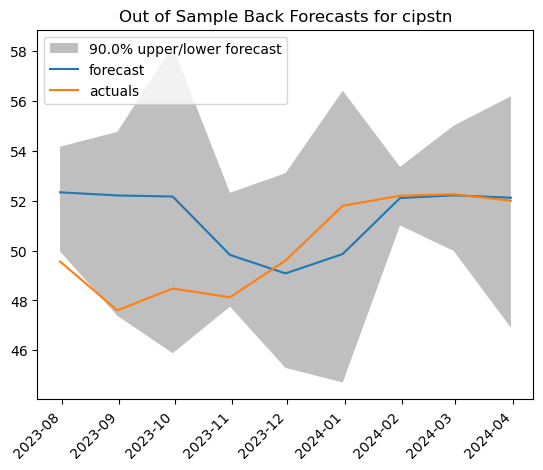

In [29]:
model

### Step 5: Fit the model

### Step 6: Predict using our model

### Step 7: OOS Evaluation
Combine the previous steps into a single loop, moving through each month and storing the results